In [2]:
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq

raw_data_dir = Path("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/raw")

mESC_data_dir = raw_data_dir / "mESC_lower_max_peak_dist"
macrophage_data_dir = raw_data_dir / "macrophage"
k562_data_dir = raw_data_dir / "K562"


## mESC

In [ ]:
unique_peaks = set()
unique_genes = set()
for item in mESC_data_dir.iterdir():
    if item.is_dir():
        print(f"mESC subdir: {item.name}")
        for file in item.iterdir():
            if file.name.endswith("scATAC_seq_raw.parquet"):
                print(f"  - File: {file.name}")
                parquet_file = pq.ParquetFile(file)
                unique_peaks.update(parquet_file.schema.names)
            if file.name.endswith("scRNA_seq_raw.parquet"):
                print(f"  - File: {file.name}")
                parquet_file = pq.ParquetFile(file)
                unique_genes.update(parquet_file.schema.names)

print()
print(f"Total unique genes in mESC RNA-seq data: {len(unique_genes)}")
print(f"Total unique peaks in mESC ATAC-seq data: {len(unique_peaks)}")

## Macrophage

In [ ]:
unique_peaks = set()
unique_genes = set()
unique_cells = set()
for item in macrophage_data_dir.iterdir():
    if item.is_dir():
        print(f"macrophage subdir: {item.name}")
        for file in item.iterdir():
            if file.name.endswith(f"matched_filtered_ATAC_rawcounts_{item.name}.csv"):
                print(f"  - File: {file.name}")
                df = pd.read_csv(file)
                unique_peaks.update(df.index.tolist())
                unique_cells.update(df.columns.tolist())
            if file.name.endswith(f"matched_filtered_RNA_rawcounts_{item.name}.csv"):
                print(f"  - File: {file.name}")
                df = pd.read_csv(file)
                unique_genes.update(df.index.tolist())
                unique_cells.update(df.columns.tolist())

print()
print(f"Total unique genes in macrophage RNA-seq data: {len(unique_genes)}")
print(f"Total unique peaks in macrophage ATAC-seq data: {len(unique_peaks)}")
print(f"Total unique cells in macrophage ATAC-seq data: {len(unique_cells)}")

macrophage subdir: buffer_3
  - File: matched_filtered_ATAC_rawcounts_buffer_3.csv
  - File: matched_filtered_RNA_rawcounts_buffer_3.csv
macrophage subdir: buffer_2
  - File: matched_filtered_RNA_rawcounts_buffer_2.csv
  - File: matched_filtered_ATAC_rawcounts_buffer_2.csv
macrophage subdir: buffer_1
  - File: matched_filtered_ATAC_rawcounts_buffer_1.csv
  - File: matched_filtered_RNA_rawcounts_buffer_1.csv
macrophage subdir: buffer_4
  - File: matched_filtered_ATAC_rawcounts_buffer_4.csv
  - File: matched_filtered_RNA_rawcounts_buffer_4.csv

Total unique genes in macrophage RNA-seq data: 10063
Total unique peaks in macrophage ATAC-seq data: 271348
Total unique cells in macrophage ATAC-seq data: 1635


## K562

In [ ]:
unique_peaks = set()
unique_genes = set()
unique_cells = set()
for item in k562_data_dir.iterdir():
    if item.is_dir():
        print(f"K562 subdir: {item.name}")
        for file in item.iterdir():
            if file.name.endswith(f"K562_human_filtered_ATAC.csv"):
                print(f"  - File: {file.name}")
                df = pd.read_csv(file)
                unique_peaks.update(df.index.tolist())
                unique_cells.update(df.columns.tolist())
            if file.name.endswith(f"K562_human_filtered_RNA.csv"):
                print(f"  - File: {file.name}")
                df = pd.read_csv(file)
                unique_genes.update(df.index.tolist())
                unique_cells.update(df.columns.tolist())

print()
print(f"Total unique cells in K562 ATAC-seq data: {len(unique_cells)}")
print(f"Total unique genes in K562 RNA-seq data: {len(unique_genes)}")
print(f"Total unique peaks in K562 ATAC-seq data: {len(unique_peaks)}")


K562 subdir: sample_1
  - File: K562_human_filtered_RNA.csv
  - File: K562_human_filtered_ATAC.csv

Total unique genes in K562 RNA-seq data: 10012
Total unique peaks in K562 ATAC-seq data: 177439
Total unique cells in K562 ATAC-seq data: 412


## Best Experiment Results

2 Hops, 40k distance scale factor, higher max peak distance

In [3]:
mESC_exp_name = "mESC_slow_decay_long_range_two_hop"
macrophage_exp_name = "Macrophage_two_hops_slow_decay_long_range_small_batch"
k562_exp_name = "K562_two_hops_slow_decay_long_range"

experiment_dir = Path(f"/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments")

def open_auc_data_files(exp_name: str, model_num: int = 1):
    exp_path = experiment_dir / exp_name / "chr19" / f"model_training_{model_num:03d}"
    per_tf_df = pd.read_csv(exp_path / "per_tf_auroc_auprc_detailed.csv", header=0, index_col=None)
    per_gt_df = pd.read_csv(exp_path / "per_gt_method_aucs_detailed.csv", header=0, index_col=None)
    return per_tf_df, per_gt_df

k562_per_tf_df, k562_per_gt_df = open_auc_data_files(k562_exp_name)
mESC_per_tf_df, mESC_per_gt_df = open_auc_data_files(mESC_exp_name)
macrophage_per_tf_df, macrophage_per_gt_df = open_auc_data_files(macrophage_exp_name)



In [4]:
def calculate_mean_auroc_for_method(per_gt_df: pd.DataFrame, method_name: str) -> float:
    return per_gt_df[per_gt_df["name"] == method_name]["auroc"].mean()

def calculate_mean_per_tf_auroc(per_tf_df: pd.DataFrame, method_name: str) -> float:
    # Select only rows for the specified method
    per_tf_mean_by_method = per_tf_df[per_tf_df["method"] == method_name]
    
    # Calculate the mean AUROC per ground truth for all TFs
    per_tf_mean_score = per_tf_mean_by_method.groupby("tf")["auroc"].mean().reset_index()
    
    # Calculate the mean AUROC across all ground truths
    per_tf_mean_by_gt = per_tf_mean_score["auroc"].mean()
    
    return per_tf_mean_by_gt

method_list = ["Gradient Attribution", "TF Knockout"]
for method in method_list:
    k562_mean_per_tf_auroc = calculate_mean_per_tf_auroc(k562_per_tf_df, method)
    macrophage_mean_per_tf_auroc = calculate_mean_per_tf_auroc(macrophage_per_tf_df, method)
    mESC_mean_per_tf_auroc = calculate_mean_per_tf_auroc(mESC_per_tf_df, method)
    
    k562_mean_auroc = calculate_mean_auroc_for_method(k562_per_gt_df, method)
    macrophage_mean_auroc = calculate_mean_auroc_for_method(macrophage_per_gt_df, method)
    mESC_mean_auroc = calculate_mean_auroc_for_method(mESC_per_gt_df, method)
    
    print(method)
    print(f"  - Mean AUROC:")
    print(f"    - mESC: {mESC_mean_auroc:.3f}")
    print(f"    - Macrophage: {macrophage_mean_auroc:.3f}")
    print(f"    - K562: {k562_mean_auroc:.3f}")
    print() 
    
    print(f"  - Mean per-TF AUROC:")
    print(f"    - mESC: {mESC_mean_per_tf_auroc:.3f}")
    print(f"    - Macrophage: {macrophage_mean_per_tf_auroc:.3f}")
    print(f"    - K562: {k562_mean_per_tf_auroc:.3f}")
    print()


Gradient Attribution
  - Mean AUROC:
    - mESC: 0.540
    - Macrophage: 0.551
    - K562: 0.538

  - Mean per-TF AUROC:
    - mESC: 0.581
    - Macrophage: 0.563
    - K562: 0.564

TF Knockout
  - Mean AUROC:
    - mESC: 0.532
    - Macrophage: 0.552
    - K562: 0.525

  - Mean per-TF AUROC:
    - mESC: 0.562
    - Macrophage: 0.557
    - K562: 0.556



In [5]:
import matplotlib.pyplot as plt
import numpy as np
def plot_all_results_auroc_boxplot(df, per_tf=False):
    # 1. Order methods by mean AUROC (highest → lowest)
    method_order = (
        df.groupby("name")["auroc"]
        .mean()
        .sort_values(ascending=False)
        .index
    )

    # 2. Prepare data in that order
    data = [df.loc[df["name"] == m, "auroc"].values for m in method_order]

    feature_list = [
        "Gradient Attribution",
        "TF Knockout",
        "TF-TG Embedding Similarity",
        "Shortcut Attention"
    ]
    my_color = "#4195df"
    other_color = "#747474"

    fig, ax = plt.subplots(figsize=(10, 6))

    # Baseline random line
    ax.axhline(y=0.5, color="#2D2D2D", linestyle='--', linewidth=1)

    # --- Boxplot (existing styling) ---
    bp = ax.boxplot(
        data,
        tick_labels=method_order,
        patch_artist=True,
        showfliers=False
    )

    # Color boxes: light blue for your methods, grey for others
    for box, method in zip(bp["boxes"], method_order):
        if method in feature_list:
            box.set_facecolor(my_color)
        else:
            box.set_facecolor(other_color)

    # Medians in black
    for median in bp["medians"]:
        median.set_color("black")

    # --- NEW: overlay jittered points for each method ---
    for i, method in enumerate(method_order, start=1):
        y = df.loc[df["name"] == method, "auroc"].values
        if len(y) == 0:
            continue

        # Small horizontal jitter around the box center (position i)
        x = np.random.normal(loc=i, scale=0.06, size=len(y))

        # Match point color to box color
        point_color = my_color if method in feature_list else other_color

        ax.scatter(
            x, y,
            color=point_color,
            alpha=0.7,
            s=18,
            edgecolor="k",
            linewidth=0.3,
            zorder=3,
        )
        
        mean_val = y.mean()
        ax.scatter(
            i, mean_val,
            color="white",
            edgecolor="k",
            s=30,
            zorder=4,
        )

    ax.set_xlabel("Method")
    ax.set_ylabel("AUROC across ground truths")
    if per_tf == True:
        ax.set_title("per-TF AUROC Scores per method")
        ax.set_ylim((0.2, 0.8))
    else:
        ax.set_title("AUROC Scores per method")
        ax.set_ylim((0.2, 0.8))

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    
    return fig

In [6]:
def per_tf_method_one(per_tf_metrics: pd.DataFrame):
    # ===== Method 1: Mean of Each TF per Ground Truth =====
    method_gt_avg = (
        per_tf_metrics
        .groupby(['method', 'gt_name'], as_index=False)
        .agg(
            auroc=('auroc', 'mean'),
            auprc=('auprc', 'mean'),
            n_tfs=('tf', 'nunique'),
        )
    )

    method_gt_avg.rename(columns={'method': 'name'}, inplace=True)

    # Plot the boxplots and save data
    per_tf_mean_auroc_boxplot = plot_all_results_auroc_boxplot(method_gt_avg, per_tf=True)
    per_tf_mean_auroc_boxplot.show()

def per_tf_method_two(per_tf_metrics: pd.DataFrame):
    per_tf_for_plot = per_tf_metrics[['method', 'auroc', 'auprc']].copy()
    per_tf_for_plot = per_tf_for_plot.rename(columns={'method': 'name'})
    

    # Plot the boxplots and save data like above methods
    per_tf_mean_auroc_boxplot = plot_all_results_auroc_boxplot(per_tf_for_plot, per_tf=True)
    per_tf_mean_auroc_boxplot.show()

def per_tf_method_three(per_tf_metrics: pd.DataFrame):
    # ===== Method 3: Calculate the Mean TF AUROC/AUPRC Across All GTs =====
    per_tf_mean_across_gt = (
        per_tf_metrics
        .groupby(['method', 'tf'], as_index=False)
        .agg(
            auroc=('auroc', 'mean'),
            auprc=('auprc', 'mean'),
            n_gt=('gt_name', 'nunique'),
        )
    )

    per_tf_mean_across_gt.rename(columns={'method': 'name'}, inplace=True)

        #Plot the boxplots and save data like above methods
    per_tf_mean_auroc_boxplot = plot_all_results_auroc_boxplot(per_tf_mean_across_gt, per_tf=True)
    per_tf_mean_auroc_boxplot.show()

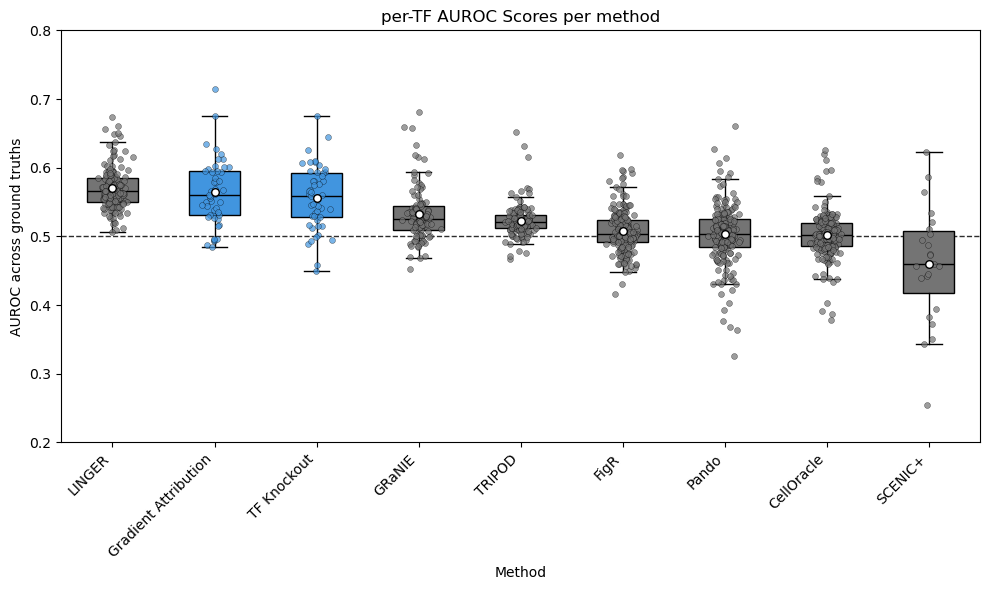

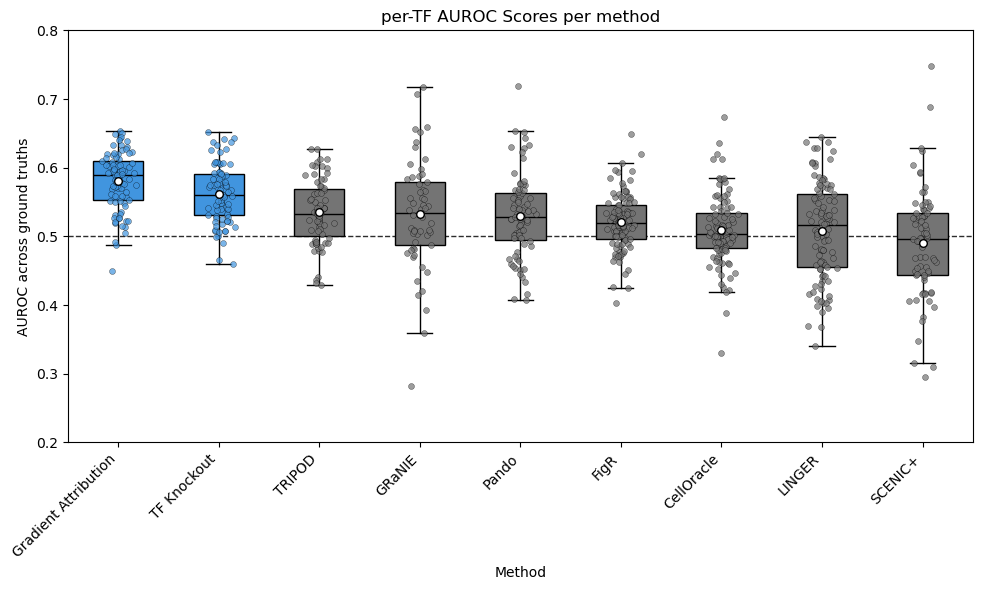

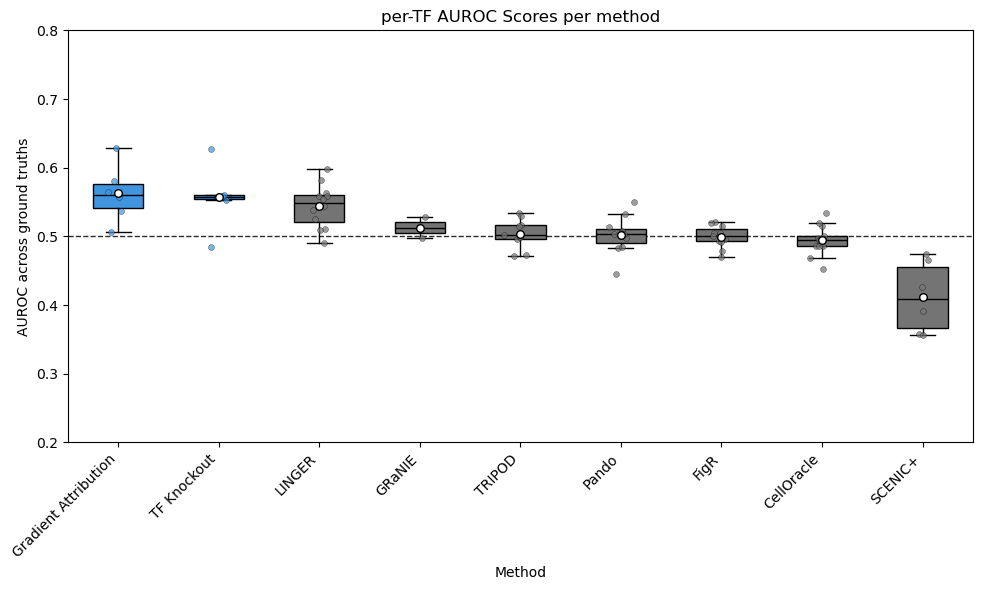

In [90]:
# Calculate and plot per-TF method rankings using different approaches
per_tf_method_three(k562_per_tf_df)
per_tf_method_three(mESC_per_tf_df)
per_tf_method_three(macrophage_per_tf_df)

## Testing K562 Stability refactored model results

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stability_boxplots_by_experiment(df, per_tf=True, method_name="Gradient Attribution"):
    # Filter to GA only
    d = df[df["method"] == method_name].copy()
    if d.empty:
        raise ValueError(f"No rows found for method '{method_name}'. Available methods: {df['method'].unique()}")

    # Order experiments as they appear (or sort)
    exp_order = list(dict.fromkeys(d["experiment"].tolist()))
    data = [d.loc[d["experiment"] == e, "auroc"].dropna().to_numpy() for e in exp_order]

    fig, ax = plt.subplots(figsize=(6.5, 5))
    ax.axhline(0.5, color="#2D2D2D", linestyle="--", linewidth=1)

    bp = ax.boxplot(
        data,
        tick_labels=exp_order,
        patch_artist=True,
        showfliers=False
    )

    # style
    for box in bp["boxes"]:
        box.set_facecolor("#4195df")
    for med in bp["medians"]:
        med.set_color("black")

    # mean markers
    for i, e in enumerate(exp_order, start=1):
        y = d.loc[d["experiment"] == e, "auroc"].dropna().to_numpy()
        if y.size == 0:
            continue

        ax.scatter(i, y.mean(), color="white", edgecolor="k",
                   s=30, zorder=4)

    ax.set_xlabel("Stability experiment")
    
    if per_tf == True:
        ax.set_ylabel("per-TF AUROC")
        ax.set_title(f"{method_name} per-TF AUROC by stability experiment")
    else:
        ax.set_ylabel("AUROC")
        ax.set_title(f"{method_name} AUROC by stability experiment")

    ax.set_ylim((0.2, 0.8) if per_tf else (0.2, 0.8))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    return fig


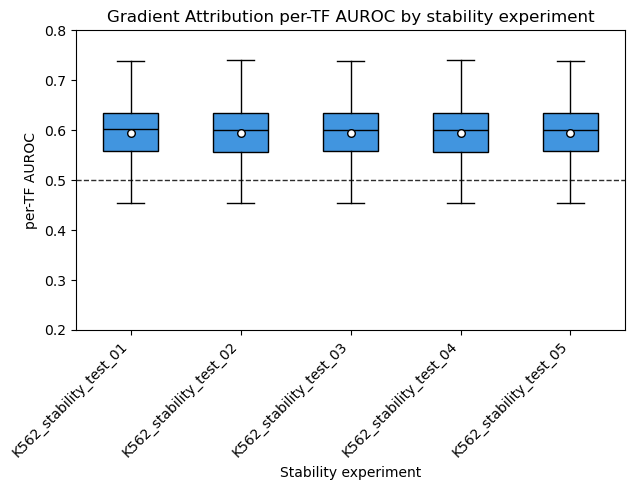

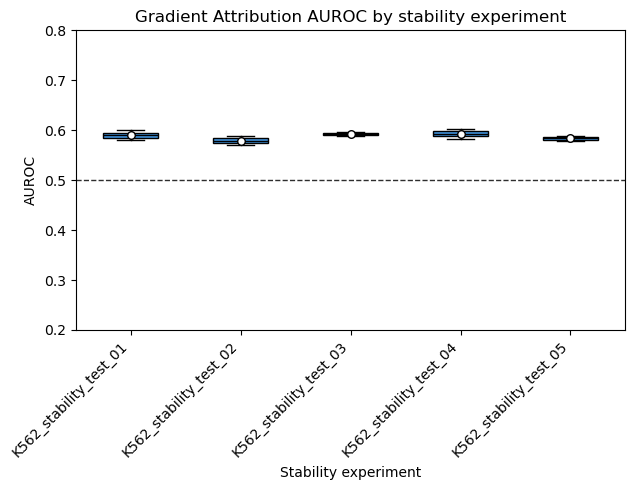

In [111]:
from sqlalchemy import all_


stability_experiments = [
    "K562_stability_test_01",
    "K562_stability_test_02",
    "K562_stability_test_03",
    "K562_stability_test_04",
    "K562_stability_test_05",
]

for stability_exp in stability_experiments:
    stability_per_tf_df, stability_per_gt_df = open_auc_data_files(stability_exp)
    
# Plotting boxplots with all stability experiments together
all_stability_per_tf_dfs = []
all_stability_per_gt_dfs = []
for stability_exp in stability_experiments:
    stability_per_tf_df, stability_per_gt_df = open_auc_data_files(stability_exp)
    stability_per_tf_df['experiment'] = stability_exp
    stability_per_gt_df['experiment'] = stability_exp
    all_stability_per_tf_dfs.append(stability_per_tf_df)
    all_stability_per_gt_dfs.append(stability_per_gt_df)
    
combined_stability_per_tf_df = pd.concat(all_stability_per_tf_dfs, ignore_index=True)
combined_stability_per_gt_df = pd.concat(all_stability_per_gt_dfs, ignore_index=True)

fig = plot_stability_boxplots_by_experiment(combined_stability_per_tf_df, method_name="Gradient Attribution", per_tf=True)
plt.show()

combined_stability_per_gt_df = combined_stability_per_gt_df.rename(columns={'name': 'method'})
fig = plot_stability_boxplots_by_experiment(combined_stability_per_gt_df, method_name="Gradient Attribution", per_tf=False)
plt.show()

## Comparing Results From HVG Filtering

In [8]:
def plot_hvg_comparison_bar(df, per_tf=False, exp_name=""):
    # Order methods by mean AUROC
    stats = (
        df.groupby("name")["auroc"]
        .agg(["mean", "std", "count"])
        .sort_values("mean", ascending=False)
    )
    stats["sem"] = stats["std"] / np.sqrt(stats["count"])

    methods = stats.index.tolist()
    means   = stats["mean"].values
    sems    = stats["sem"].values

    feature_list = [
        "Gradient Attribution",
        "TF Knockout",
        "TF-TG Embedding Similarity",
        "Shortcut Attention"
    ]

    my_color = "#4195df"
    other_color = "#747474"

    fig, ax = plt.subplots(figsize=(10, 5))

    x = np.arange(len(methods))

    # Baseline random line
    ax.axhline(0.5, color="#2D2D2D", linestyle="--", linewidth=1)

    # --- Bar plot ---
    bars = ax.bar(
        x,
        means,
        yerr=sems,
        capsize=10,
        width=0.5,
        color=my_color,
        edgecolor="black",
        linewidth=0.8,
        zorder=2,
    )
    
    for bar, method in zip(bars, methods):
        if method in feature_list:
            bar.set_facecolor(my_color)
        else:
            bar.set_facecolor(other_color)

    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=25, ha="right")

    ax.set_xlabel("Method")
    ax.set_ylabel("AUROC across ground truths")

    if per_tf:
        ax.set_title(f"Per-TF AUROC Scores per Method - {exp_name}")
        ax.set_ylim(0.0, 1.0)
    else:
        ax.set_title(f"AUROC Scores per Method - {exp_name}")
        ax.set_ylim(0.2, 0.8)

    plt.tight_layout()
    return fig


In [ ]:
def plot_hvg_comparison_boxplot(df, per_tf=False, exp_name=""):
    import numpy as np
    import matplotlib.pyplot as plt

    # ---- order methods by mean AUROC ----
    stats = (
        df.groupby("name")["auroc"]
          .mean()
          .sort_values(ascending=False)
    )
    methods = stats.index.tolist()

    feature_list = [
        "Gradient Attribution",
        "TF Knockout",
        "TF-TG Embedding Similarity",
        "Shortcut Attention",
    ]

    my_color = "#4195df"
    other_color = "#747474"

    # ---- collect AUROC values per method in sorted order ----
    data = [df.loc[df["name"] == m, "auroc"].values for m in methods]

    fig, ax = plt.subplots(figsize=(10, 5))

    # Baseline random line
    ax.axhline(0.5, color="#2D2D2D", linestyle="--", linewidth=1, zorder=1)

    # ---- boxplot ----
    bp = ax.boxplot(
        data,
        widths=0.55,
        patch_artist=True,
        showfliers=False,
        medianprops=dict(color="black", linewidth=1.5),
        boxprops=dict(linewidth=0.8),
        whiskerprops=dict(linewidth=0.8),
        capprops=dict(linewidth=0.8),
    )

    # ---- color boxes ----
    for box, method in zip(bp["boxes"], methods):
        if method in feature_list:
            box.set_facecolor(my_color)
        else:
            box.set_facecolor(other_color)
        box.set_edgecolor("black")
        
        # --- NEW: overlay jittered points for each method ---
    for i, method in enumerate(methods, start=1):
        y = df.loc[df["name"] == method, "auroc"].values
        if len(y) == 0:
            continue

        # Small horizontal jitter around the box center (position i)
        x = np.random.normal(loc=i, scale=0.06, size=len(y))

        # Match point color to box color
        point_color = my_color if method in feature_list else other_color

        ax.scatter(
            x, y,
            color=point_color,
            alpha=0.7,
            s=18,
            edgecolor="k",
            linewidth=0.3,
            zorder=3,
        )
        
        mean_val = y.mean()
        ax.scatter(
            i, mean_val,
            color="white",
            edgecolor="k",
            s=30,
            zorder=4,
        )

    # ---- x axis ----
    ax.set_xticks(np.arange(1, len(methods) + 1))
    ax.set_xticklabels(methods, rotation=25, ha="right")

    ax.set_xlabel("Method")
    ax.set_ylabel("AUROC across ground truths")

    if per_tf:
        ax.set_title(f"Per-TF AUROC Scores per Method - {exp_name}")
        ax.set_ylim(0.3, 0.7)
    else:
        ax.set_title(f"AUROC Scores per Method - {exp_name}")
        ax.set_ylim(0.3, 0.7)

    plt.tight_layout()
    return fig


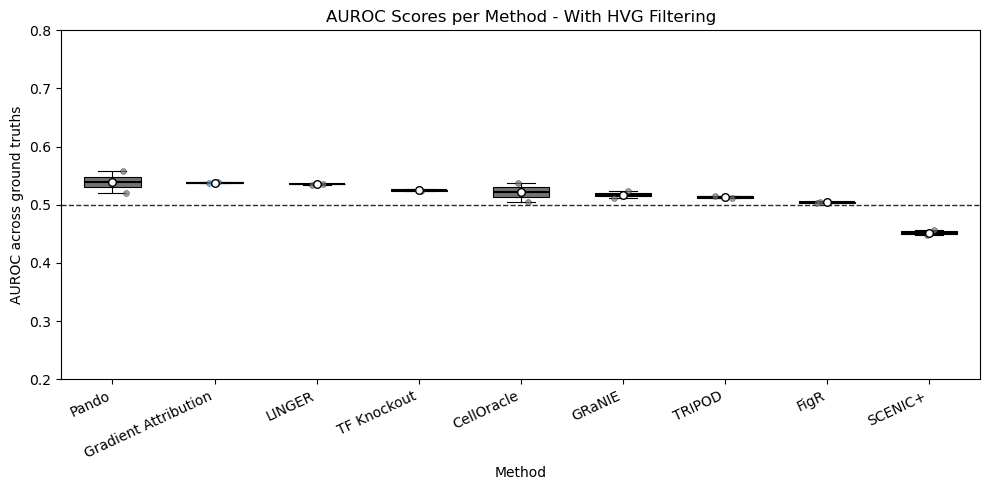

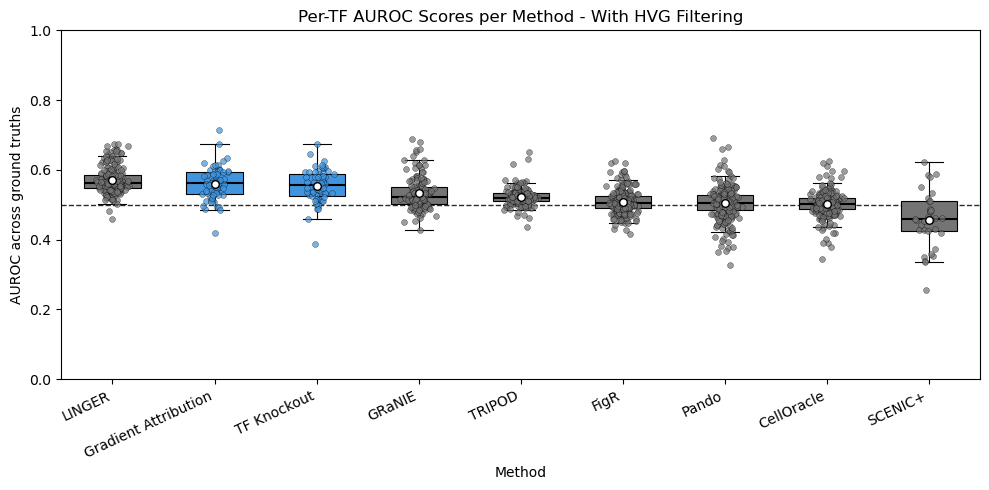

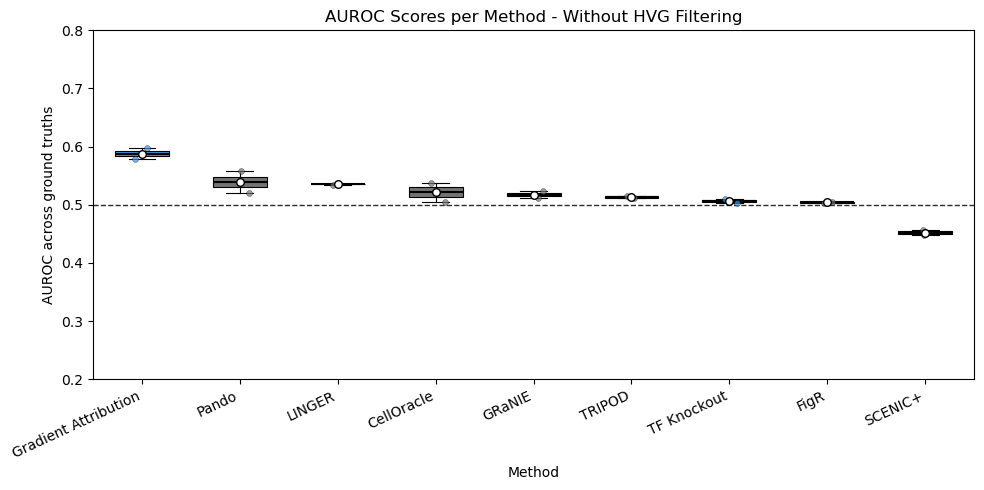

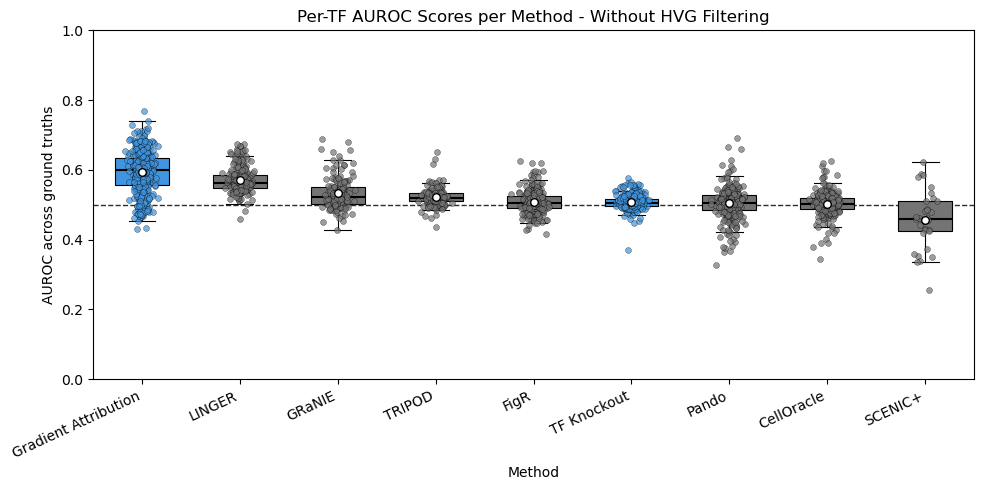

In [12]:
experiments_to_compare = {
    "With HVG Filtering": "K562_two_hops_slow_decay_long_range",
    "Without HVG Filtering": "K562_two_hops_slow_decay_long_range_no_hvg",
}

# Plotting boxplots with all stability experiments together
all_per_tf_dfs = []
all_exp_gt_dfs = []
for experiment_name, experiment in experiments_to_compare.items():
    exp_per_tf_df, exp_per_gt_df = open_auc_data_files(experiment)
    exp_per_gt_df["method"] = "Gradient Attribution"
    all_per_tf_dfs.append(exp_per_tf_df)
    all_exp_gt_dfs.append(exp_per_gt_df)
    
    fig = plot_hvg_comparison_boxplot(exp_per_gt_df, per_tf=False, exp_name=experiment_name)
    
    fig.show()
    
    exp_per_tf_df = exp_per_tf_df.rename(columns={'method': 'name'})
    fig = plot_hvg_comparison_boxplot(exp_per_tf_df, per_tf=True, exp_name=experiment_name)
    fig.show()


K562 with HVG filtering - Gradient Attribution mean AUROC: 0.538
K562 without HVG filtering - Gradient Attribution mean AUROC: 0.588


/tmp/ipykernel_2478545/2364241067.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grad_attrib_k562_no_hvg["name"] = "Gradient Attribution\nNo HVG"
/tmp/ipykernel_2478545/2364241067.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grad_attrib_k562_hvg["name"] = "Gradient Attribution\nWith HVG"


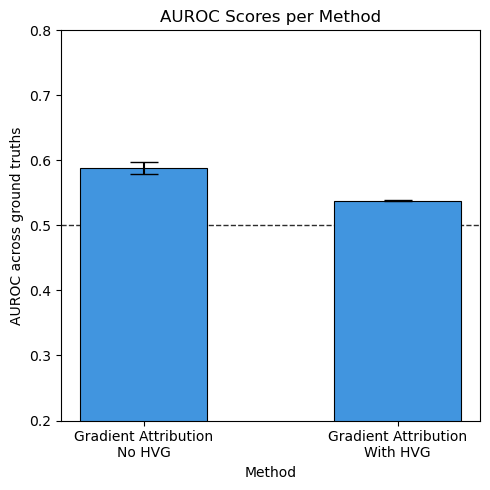

In [71]:
k562_no_hvg_mean_auroc = calculate_mean_auroc_for_method(all_exp_gt_dfs[1], "Gradient Attribution")
k562_hvg_mean_auroc = calculate_mean_auroc_for_method(all_exp_gt_dfs[0], "Gradient Attribution")
print(f"K562 with HVG filtering - Gradient Attribution mean AUROC: {k562_hvg_mean_auroc:.3f}")
print(f"K562 without HVG filtering - Gradient Attribution mean AUROC: {k562_no_hvg_mean_auroc:.3f}")

grad_attrib_k562_no_hvg = all_exp_gt_dfs[1][all_exp_gt_dfs[1]["name"] == "Gradient Attribution"]
grad_attrib_k562_no_hvg["name"] = "Gradient Attribution\nNo HVG"
grad_attrib_k562_hvg = all_exp_gt_dfs[0][all_exp_gt_dfs[0]["name"] == "Gradient Attribution"]
grad_attrib_k562_hvg["name"] = "Gradient Attribution\nWith HVG"

combined_df = pd.concat([grad_attrib_k562_no_hvg, grad_attrib_k562_hvg], ignore_index=True)
fig = plot_hvg_comparison_bar(combined_df, per_tf=False)
fig.show()

K562 with HVG filtering - Gradient Attribution per-TF AUROC: 0.564
K562 without HVG filtering - Gradient Attribution per-TF AUROC: 0.586


/tmp/ipykernel_2478545/735133391.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grad_attrib_k562_no_hvg["name"] = "Gradient Attribution\nNo HVG"
/tmp/ipykernel_2478545/735133391.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grad_attrib_k562_hvg["name"] = "Gradient Attribution\nWith HVG"


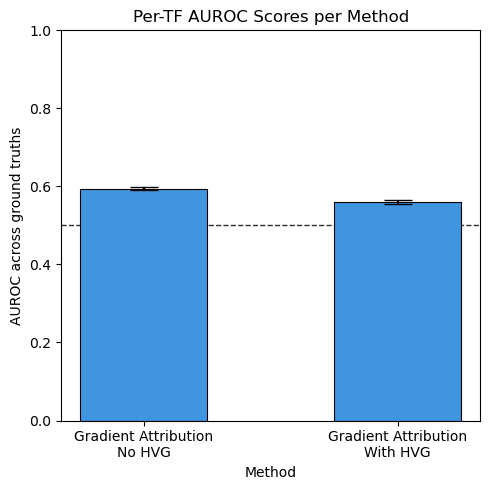

In [82]:
k562_no_hvg_mean_auroc = calculate_mean_per_tf_auroc(all_per_tf_dfs[1], "Gradient Attribution")
k562_hvg_mean_auroc = calculate_mean_per_tf_auroc(all_per_tf_dfs[0], "Gradient Attribution")
print(f"K562 with HVG filtering - Gradient Attribution per-TF AUROC: {k562_hvg_mean_auroc:.3f}")
print(f"K562 without HVG filtering - Gradient Attribution per-TF AUROC: {k562_no_hvg_mean_auroc:.3f}")

grad_attrib_k562_no_hvg = all_per_tf_dfs[1][all_per_tf_dfs[1]["method"] == "Gradient Attribution"]
grad_attrib_k562_no_hvg["name"] = "Gradient Attribution\nNo HVG"
grad_attrib_k562_hvg = all_per_tf_dfs[0][all_per_tf_dfs[0]["method"] == "Gradient Attribution"]
grad_attrib_k562_hvg["name"] = "Gradient Attribution\nWith HVG"

combined_df = pd.concat([grad_attrib_k562_no_hvg, grad_attrib_k562_hvg], ignore_index=True)
fig = plot_hvg_comparison_bar(combined_df, per_tf=True)
fig.show()

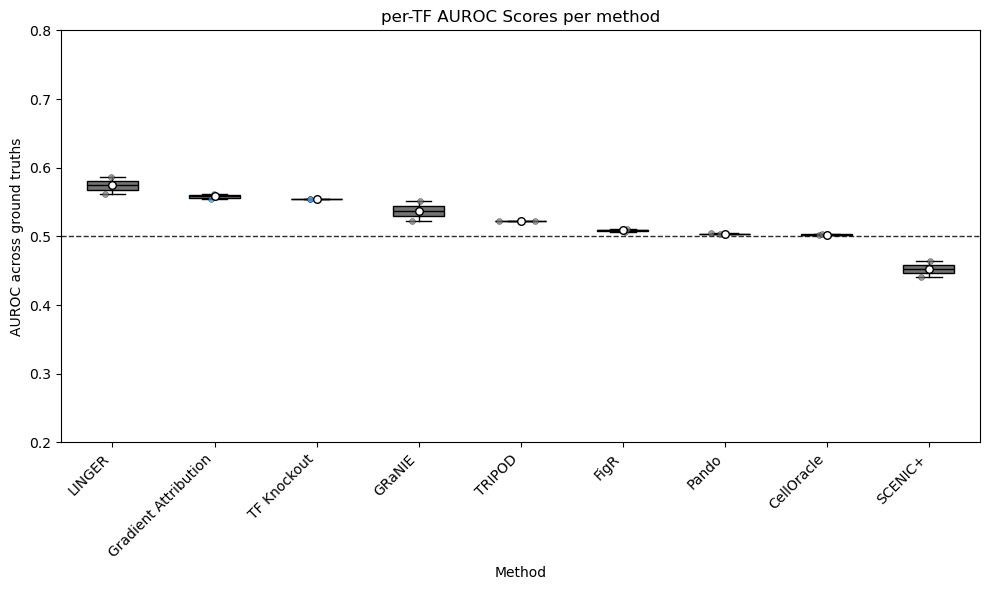

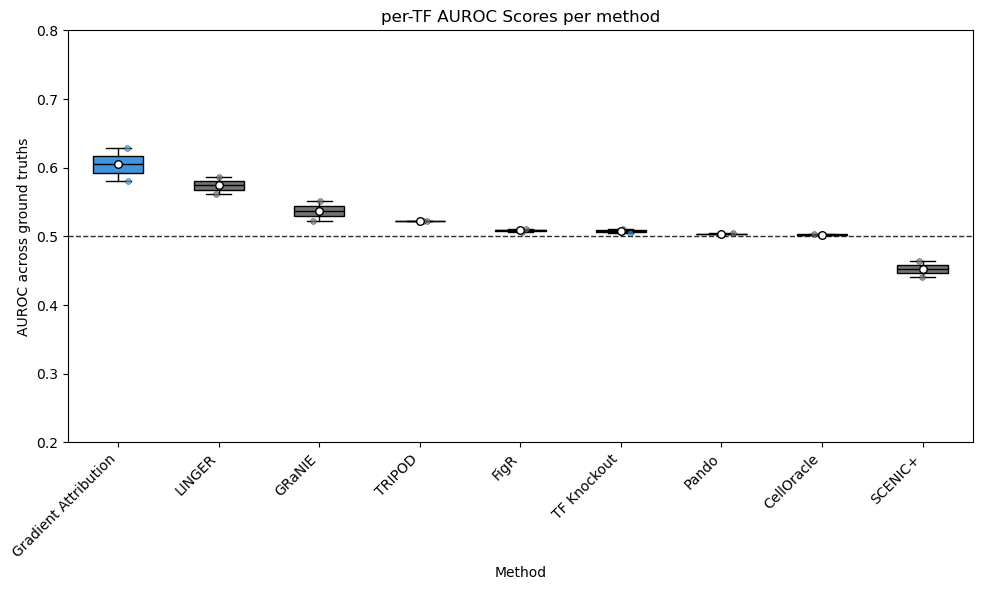

In [92]:
per_tf_method_one(all_per_tf_dfs[0])
per_tf_method_one(all_per_tf_dfs[1])

## HVG Filter Testing

Model testing settings:
- `HOPS`=2
- `D_MODEL`=128
- `D_FF`=512
- `BATCH_SIZE`=32
- `TOTAL_EPOCHS`=100

In [129]:
data = {
    "Experiment": [
        "Dispersion 0.6",
        "Dispersion 0.5",
        "Dispersion 0.4",
        "Dispersion 0.3",
        "Dispersion 0.2",
        "Dispersion 0.1",
        "Dispersion 0.05",
        "Dispersion 0.01",
        "No HVG Filtering",
    ],
    "TFs": [115, 134, 160, 181, 211, 238, 253, 272, 766],
    "TGs": [1699, 1889, 2109, 2372, 2671, 3026, 3221, 3670, 9210],
    "Peaks": [37385, 42507, 48321, 53509, 60138, 67031, 68513, 76120, 153151],
}
df = pd.DataFrame(data)
df

,Experiment,TFs,TGs,Peaks
0,Dispersion 0.6,115,1699,37385
1,Dispersion 0.5,134,1889,42507
2,Dispersion 0.4,160,2109,48321
3,Dispersion 0.3,181,2372,53509
4,Dispersion 0.2,211,2671,60138
5,Dispersion 0.1,238,3026,67031
6,Dispersion 0.05,253,3221,68513
7,Dispersion 0.01,272,3670,76120
8,No HVG Filtering,766,9210,153151


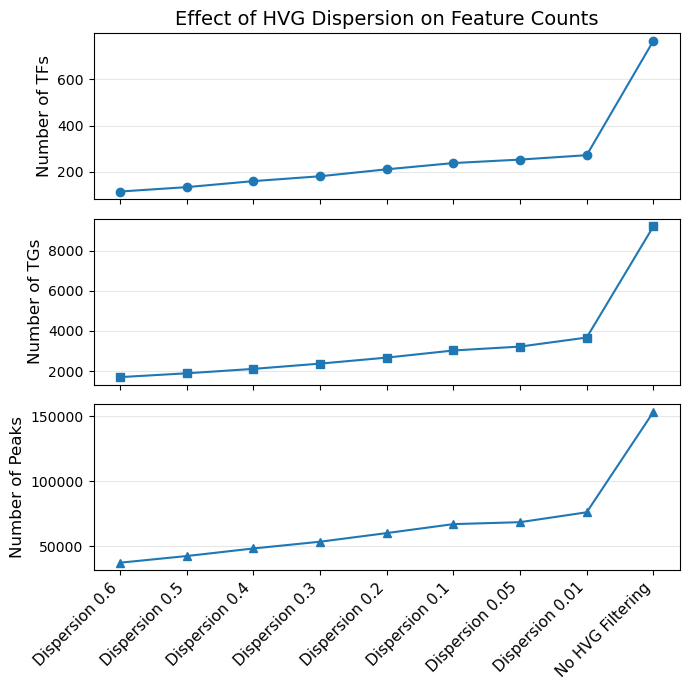

In [130]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(7, 7),
    sharex=True
)

# --- TFs ---
axes[0].plot(
    df["Experiment"],
    df["TFs"],
    marker="o",
)
axes[0].set_ylabel("Number of TFs", fontsize=12)
axes[0].set_title("Effect of HVG Dispersion on Feature Counts", fontsize=14)

# --- TGs ---
axes[1].plot(
    df["Experiment"],
    df["TGs"],
    marker="s",
)
axes[1].set_ylabel("Number of TGs", fontsize=12)

# --- Peaks ---
axes[2].plot(
    df["Experiment"],
    df["Peaks"],
    marker="^",
)
axes[2].set_ylabel("Number of Peaks", fontsize=12)

# --- X tick formatting ---
axes[2].set_xticks(range(len(df["Experiment"])))
axes[2].set_xticklabels(
    df["Experiment"],
    rotation=45,
    ha="right",
    fontsize=11,
)

# --- Aesthetics ---
for ax in axes:
    ax.grid(True, axis="y", alpha=0.3)

fig.tight_layout()
plt.show()


In [131]:
def plot_hvg_series_boxplot(df, per_tf=False, exp_name=""):
    import numpy as np
    import matplotlib.pyplot as plt

    # Ensure we have what we expect
    assert "name" in df.columns, "Expected df['name'] to hold experiment labels"
    assert "auroc" in df.columns, "Expected df['auroc'] to exist"

    # ---- order experiments by mean AUROC (high -> low) ----
    means = df.groupby("name")["auroc"].mean()
    exps = means.index.tolist()

    data = [df.loc[df["name"] == e, "auroc"].dropna().values for e in exps]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axhline(0.5, color="#2D2D2D", linestyle="--", linewidth=1, zorder=1)

    bp = ax.boxplot(
        data,
        widths=0.55,
        patch_artist=True,
        showfliers=False,
        medianprops=dict(color="black", linewidth=1.5),
        boxprops=dict(linewidth=0.8),
        whiskerprops=dict(linewidth=0.8),
        capprops=dict(linewidth=0.8),
    )

    # Color all boxes the same (since all are Gradient Attribution)
    box_color = "#4195df"
    for box in bp["boxes"]:
        box.set_facecolor(box_color)
        box.set_edgecolor("black")

    # ---- overlay jittered points + mean markers ----
    for i, e in enumerate(exps, start=1):
        y = df.loc[df["name"] == e, "auroc"].dropna().values
        if len(y) == 0:
            continue

        x = np.random.normal(loc=i, scale=0.06, size=len(y))
        ax.scatter(
            x, y,
            color=box_color,
            alpha=0.6,
            s=18,
            edgecolor="k",
            linewidth=0.3,
            zorder=3,
        )

        mean_val = y.mean()
        ax.scatter(
            i, mean_val,
            color="white",
            edgecolor="k",
            s=35,
            zorder=4,
        )
        # optional: annotate mean
        ax.text(i, y.max() + 0.015, f"{mean_val:.3f}", ha="center", va="bottom", fontsize=12)

    ax.set_xticks(np.arange(1, len(exps) + 1))
    ax.set_xticklabels(exps, rotation=25, ha="right", fontsize=11)

    ax.set_ylabel("AUROC across ground truths", fontsize=12)

    ax.set_title(f"{'Per-TF ' if per_tf else ''}AUROC (Gradient Attribution) - {exp_name}", fontsize=14)

    ax.set_ylim(0.3, 0.7)
    plt.tight_layout()
    return fig


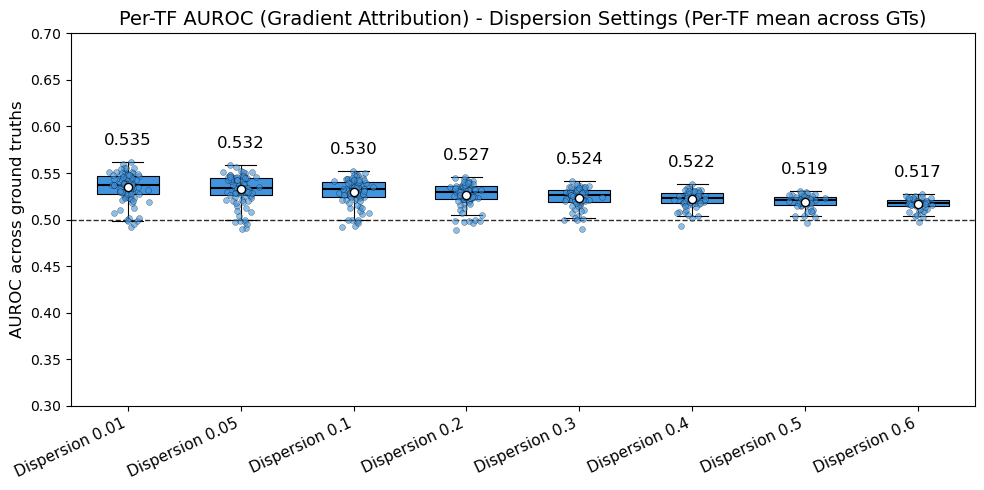

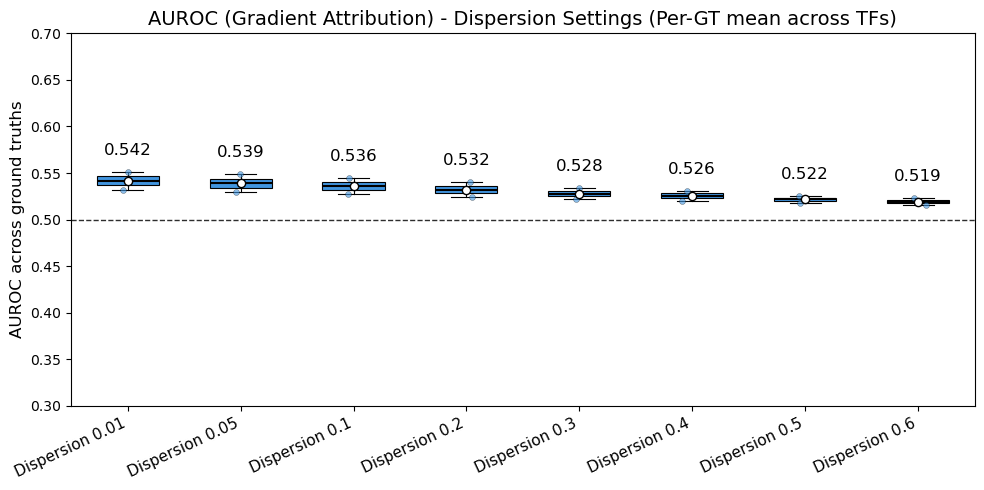

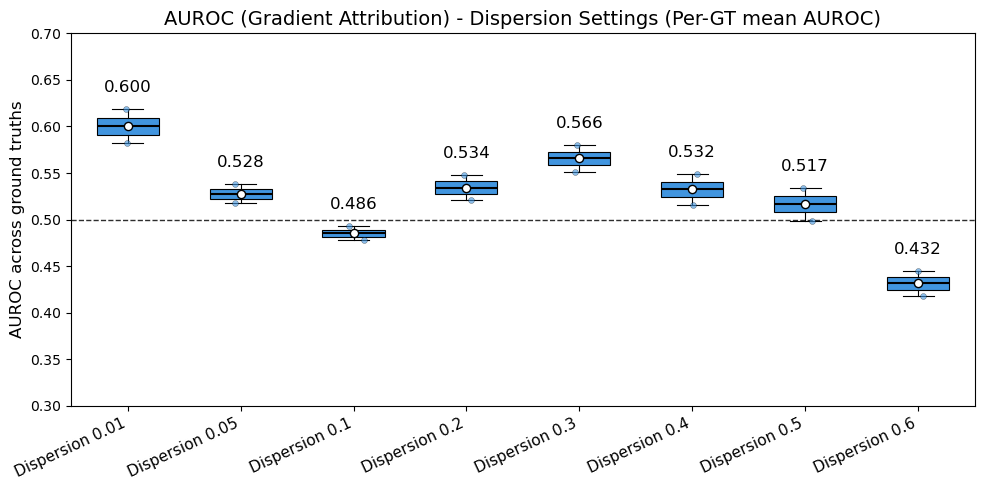

In [139]:
experiments_to_compare = {
        "Dispersion 0.6": "K562_hvg_filter_disp_0.6",
        "Dispersion 0.5": "K562_hvg_filter_disp_0.5",
        "Dispersion 0.4": "K562_hvg_filter_disp_0.4",
        "Dispersion 0.3": "K562_hvg_filter_disp_0.3",
        "Dispersion 0.2": "K562_hvg_filter_disp_0.2",
        "Dispersion 0.1": "K562_hvg_filter_disp_0.1",
        "Dispersion 0.05": "K562_hvg_filter_disp_0.05",
        "Dispersion 0.01": "K562_hvg_filter_disp_0.01",
        # "No Filtering": "K562_hvg_filter_none",
}

# Plotting boxplots with all stability experiments together
all_per_tf_dfs = []
all_exp_gt_dfs = []
for experiment_name, experiment in experiments_to_compare.items():
    exp_per_tf_df, exp_per_gt_df = open_auc_data_files(experiment)
    
    exp_per_tf_df = exp_per_tf_df[exp_per_tf_df["method"] == "Gradient Attribution"]
    
    exp_per_gt_df = exp_per_gt_df.rename(columns={'name': 'method'})
    exp_per_gt_df = exp_per_gt_df[exp_per_gt_df["method"] == "Gradient Attribution"]
    
    exp_per_tf_df["name"] = experiment_name
    exp_per_gt_df["name"] = experiment_name
    
    all_per_tf_dfs.append(exp_per_tf_df)
    all_exp_gt_dfs.append(exp_per_gt_df)
    

per_tf_combined_df = pd.concat(all_per_tf_dfs, ignore_index=True)
per_gt_combined_df = pd.concat(all_exp_gt_dfs, ignore_index=True)

per_tf_mean_df = (
    per_tf_combined_df
    .groupby(["name", "tf"], as_index=False)["auroc"]
    .mean()
)

per_tf_fig = plot_hvg_series_boxplot(
    per_tf_mean_df,   # now each row is one TF
    per_tf=True,
    exp_name="Dispersion Settings (Per-TF mean across GTs)"
)

per_gt_mean_tf_df = (
    per_tf_combined_df
    .groupby(["name", "gt_name"], as_index=False)["auroc"]
    .mean()
)

per_gt_fig = plot_hvg_series_boxplot(
    per_gt_mean_tf_df,   # now each row is one GT
    per_tf=False,
    exp_name="Dispersion Settings (Per-GT mean across TFs)"
)



per_gt_mean_df = (
    per_gt_combined_df
    .groupby(["name", "gt_name"], as_index=False)["auroc"]
    .mean()
)

per_gt_fig = plot_hvg_series_boxplot(
    per_gt_mean_df,   # now each row is one GT
    per_tf=False,
    exp_name="Dispersion Settings (Per-GT mean AUROC)"
)



In [136]:
per_gt_combined_df

,gt_name,sample,method,auroc,auprc,name
0,ChIP-Atlas,POOLED,Gradient Attribution,0.418034,0.472794,Dispersion 0.6
1,RN117,POOLED,Gradient Attribution,0.445306,0.496289,Dispersion 0.6
2,ChIP-Atlas,POOLED,Gradient Attribution,0.499004,0.518339,Dispersion 0.5
3,RN117,POOLED,Gradient Attribution,0.534102,0.525318,Dispersion 0.5
4,ChIP-Atlas,POOLED,Gradient Attribution,0.515574,0.520952,Dispersion 0.4
5,RN117,POOLED,Gradient Attribution,0.549144,0.542722,Dispersion 0.4
6,ChIP-Atlas,POOLED,Gradient Attribution,0.551532,0.556332,Dispersion 0.3
7,RN117,POOLED,Gradient Attribution,0.580071,0.578161,Dispersion 0.3
8,ChIP-Atlas,POOLED,Gradient Attribution,0.520988,0.541026,Dispersion 0.2
9,RN117,POOLED,Gradient Attribution,0.547735,0.561988,Dispersion 0.2


name
Dispersion 0.1    0.536058
Dispersion 0.2    0.532253
Dispersion 0.3    0.527838
Dispersion 0.4    0.525634
Dispersion 0.5    0.521839
Name: auroc, dtype: float64


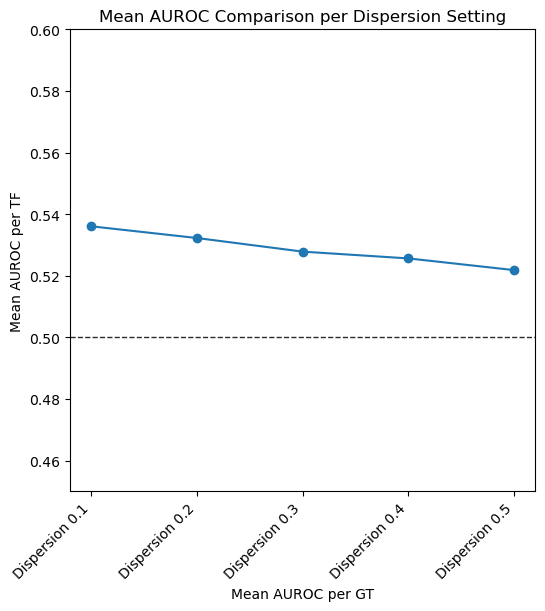

name
Dispersion 0.1    0.536058
Dispersion 0.2    0.532253
Dispersion 0.3    0.527838
Dispersion 0.4    0.525634
Dispersion 0.5    0.521839
Name: auroc, dtype: float64

In [123]:
per_gt_exp_mean = per_gt_mean_df.groupby("name")["auroc"].mean()
per_tf_exp_mean = per_tf_mean_df.groupby("name")["auroc"].mean()

print(per_gt_exp_mean)

fig = plt.figure(figsize=(6,6))
plt.plot(per_gt_exp_mean.index, per_gt_exp_mean, marker='o')

plt.axhline(0.5, color="#2D2D2D", linestyle="--", linewidth=1, zorder=1)

plt.xlabel("Mean AUROC per GT")
plt.ylabel("Mean AUROC per TF")

plt.xticks(rotation=45, ha="right")
plt.ylim(0.45, 0.6)

plt.title("Mean AUROC Comparison per Dispersion Setting")
plt.show()
per_gt_exp_mean.head()